In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import re
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Activation, Flatten, Embedding, LSTM,GRU
from keras.initializers import Constant
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import gensim
import gensim.downloader
from nltk.corpus import brown
import string

In [2]:
import nltk
nltk.download('brown')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
sents = brown.sents()
cleaned_sents = []
for i in sents:
    sentence = []
    for j in i :
        if j not in string.punctuation :
            sentence.append(j.lower())
    cleaned_sents.append(sentence)



In [4]:
model = gensim.models.Word2Vec(cleaned_sents,size=50,window=7,min_count=1)

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")  

In [6]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    lower_text = text.copy()
    for i in range(len(text)):
        lower_text[i] = text[i].lower()
    return lower_text

In [20]:
def remove_punctuation(text):
    #stop_words = set(stopwords.words('english'))
    without_punctuation_text  = text.copy()
    for i in range(len(text)):
        without_punctuation_text[i] = [w for w in text[i] if w.isalpha()]
    return without_punctuation_text

In [23]:
def perform_tokenization(text):
    tokenize_text = text.copy()
    for i in range(len(text)):
        tokenize_text[i] = nltk.word_tokenize(text[i])
    return tokenize_text

In [24]:
def get_dicts(train):
    reviews = train["reviews"]
    reviews = convert_to_lower(reviews)
    reviews = perform_tokenization(reviews)
    reviews = remove_punctuation(reviews)

    # tokenizer = Tokenizer()
    # tokenizer.fit_on_texts(train['re'])
    # words_to_index = tokenizer.word_index
    return reviews

In [41]:
review = get_dicts(train)

In [43]:
review = review.to_list()


In [61]:
max_length=50
Embedding_dimension=50

In [60]:


tokenizer_obj = Tokenizer()

tokenizer_obj.fit_on_texts(review) 
sequences = tokenizer_obj.texts_to_sequences(review)


word_index = tokenizer_obj.word_index


review_pad = pad_sequences(sequences, maxlen=max_length) 


In [64]:
num_words = len(word_index)+1

embedding_matrix = np.zeros ((num_words, Embedding_dimension))



for word, i in word_index.items():
  try:
    embedding_vector = model.wv[word]
    embedding_matrix[i] = embedding_vector
  except:
    continue
  

In [80]:
model = Sequential()

embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)

model.add(embedding_layer)

model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))

model.add (Dense (5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            797800    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                10624     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 808,589
Trainable params: 10,789
Non-trainable params: 797,800
_________________________________________________________________


In [82]:
train_rating_list = train['ratings'].to_list()
Y = [str(i-1) for i in train_rating_list]

In [89]:
y_train = tf.keras.utils.to_categorical(Y,num_classes=5)

In [91]:
model.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.2)

Epoch 1/15
625/625 [==============================] - 30s 45ms/step - loss: 1.0346 - accuracy: 0.6791 - val_loss: 1.0727 - val_accuracy: 0.5998
Epoch 2/15
625/625 [==============================] - 28s 45ms/step - loss: 0.8987 - accuracy: 0.6921 - val_loss: 1.0808 - val_accuracy: 0.6035
Epoch 3/15
625/625 [==============================] - 28s 45ms/step - loss: 0.8561 - accuracy: 0.7018 - val_loss: 1.0474 - val_accuracy: 0.6161
Epoch 4/15
625/625 [==============================] - 28s 45ms/step - loss: 0.8504 - accuracy: 0.7021 - val_loss: 0.9938 - val_accuracy: 0.6279
Epoch 5/15
625/625 [==============================] - 29s 46ms/step - loss: 0.8380 - accuracy: 0.7049 - val_loss: 0.9919 - val_accuracy: 0.6340
Epoch 6/15
625/625 [==============================] - 28s 45ms/step - loss: 0.8327 - accuracy: 0.7037 - val_loss: 1.0035 - val_accuracy: 0.6287
Epoch 7/15
625/625 [==============================] - 28s 45ms/step - loss: 0.8207 - accuracy: 0.7127 - val_loss: 0.9753 - val_accuracy:

In [92]:
def preprocess_test(test_reviews):
  reviews = test_reviews
  reviews = convert_to_lower(reviews)
  reviews = perform_tokenization(reviews)
  reviews = remove_punctuation(reviews)

  # tokenizer = Tokenizer()
  # tokenizer.fit_on_texts(train['re'])
  # words_to_index = tokenizer.word_index

  
  return reviews

In [93]:
test_review = test['reviews']
test_review = test_review.to_list()

In [94]:
sequences_test = tokenizer_obj.texts_to_sequences(test_review)
test_review_pad = pad_sequences(sequences_test, maxlen=max_length) 


In [95]:
def predict(model, test_reviews):
        # return a list containing all the ratings predicted by the trained model
        y_pred = model.predict(test_reviews)
        pred1 = []
        for i in range(len(y_pred)):
            pred1.append(np.argmax(y_pred[i])+1)
        return pred1

In [96]:
y_pred = predict(model, test_review_pad)

In [98]:
def report(y_pred,test,Model):
    Classification_report = classification_report(test['ratings'],y_pred,target_names=['1','2','3','4','5'])
    cm  = confusion_matrix(test['ratings'],y_pred)
    print("Classification Report : \n",Classification_report)
    print("Heat Map :\n")
    sns.heatmap(cm,cmap="Blues",annot=True,fmt='.4g',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])

Classification Report : 
               precision    recall  f1-score   support

           1       0.55      0.40      0.46      1271
           2       0.25      0.03      0.06       630
           3       0.34      0.23      0.27       911
           4       0.39      0.13      0.19      1404
           5       0.70      0.95      0.80      5784

    accuracy                           0.64     10000
   macro avg       0.44      0.35      0.36     10000
weighted avg       0.57      0.64      0.58     10000

Heat Map :



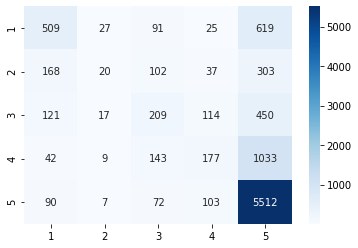

In [100]:
report(y_pred, test, model)